# Regression in PySpark's MLlib Project

Now it's time to put what you've learned to into action with a REAL project! 

You have been hired as a consultant to a cement production company who wants to be able to improve their customer experience around a number of areas like being able to provide recommendations to cusomters on optimal amounts of certian ingredients in the cement making process and perhaps even create an application where users can input their own values and received a predicted cement strength!

I have provided a list of question below to help guide you through this project but feel free to deviate and make this project your own! But first, a bit about this dataset.

### About this dataset 
This dataset contains 1030 instances of concrete samples, containing 9 attributes (8 continuous and 1 discreate), and 1 continuous quantitative output variable. There are no missing attribute values.

I've also provided the variable name, variable type, the measurement unit and a brief description of each variable in the dataset. The concrete compressive strength is the outcome variable for our analysis. The order of this listing corresponds to the order of numerals along the rows of the database.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Input Variable 
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fly Ash -- quantitative -- kg in a m3 mixture -- Input Variable 
- Water -- quantitative -- kg in a m3 mixture -- Input Variable 
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Input Variable 
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Input Variable 
- Age -- quantitative -- Day (1~365) -- Input Variable 
- Concrete compressive strength -- quantitative -- MPa -- Output Variable

**Source:** https://www.kaggle.com/maajdl/yeh-concret-data

**Dataset Name:** Concrete_Data.csv

In [8]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('REG').getOrCreate()

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [10]:
df = spark.read.csv('Datasets/Concrete_Data.csv',inferSchema=True,header=True)
df.limit(5).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [11]:
df.printSchema()

root
 |-- cement: double (nullable = true)
 |-- slag: double (nullable = true)
 |-- flyash: double (nullable = true)
 |-- water: double (nullable = true)
 |-- superplasticizer: double (nullable = true)
 |-- coarseaggregate: double (nullable = true)
 |-- fineaggregate: double (nullable = true)
 |-- age: integer (nullable = true)
 |-- csMPa: double (nullable = true)



In [19]:
df.summary().toPandas()

,summary,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,count,1030,1030,1030,1030,1030,1030,1030,1030,1030
1,mean,281.1678640776696,73.89582524271844,54.18834951456309,181.56728155339803,6.204660194174757,972.9189320388344,773.5804854368922,45.662135922330094,35.81796116504851
2,stddev,104.50636449481524,86.27934174810584,63.997004152687666,21.3542185650324,5.973841392485525,77.75395396672077,80.17598014240437,63.16991158103247,16.705741961912512
3,min,102.0,0.0,0.0,121.8,0.0,801.0,594.0,1,2.33
4,25%,192.0,0.0,0.0,164.9,0.0,932.0,730.4,7,23.7
5,50%,272.8,22.0,0.0,185.0,6.4,968.0,779.3,28,34.4
6,75%,350.0,143.0,118.3,192.0,10.2,1029.4,824.0,56,46.2
7,max,540.0,359.4,200.1,247.0,32.2,1145.0,992.6,365,82.6


In [13]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,0,0,0,0,0,0,0,0,0


## 1. Which features are the strongest predictors of cement strength?

Build your own ML model to figure this one out! This would be good information to give to our client so the sales reps can focus their efforts on certian ingredients to provide recommendations on. For example, if our clients had a customer that was struggling with their cement breaking, we could trouble shoot with them by starting with the factors that we know are important. 

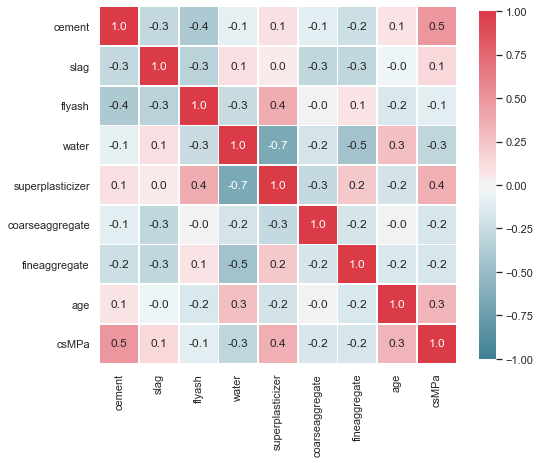

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(
    df.toPandas().corr(), 
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0, 
    center=0, 
    square=True, 
    linewidths=.5, 
    cbar_kws={"shrink": .8},
    annot=True,
    fmt='.1f'
)

In [80]:
# Split train set to a ml train set and a validation set
df_train, df_test = df.randomSplit([0.8, 0.2], seed=42)

# Functions in the pipeline
evaluator = RegressionEvaluator(labelCol='csMPa', metricName='r2')
assembler = VectorAssembler(inputCols=[c for c in df.columns if c != 'csMPa'], outputCol='features')
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=True)
reg = RandomForestRegressor(featuresCol='scaledFeatures', labelCol='csMPa')

# Definition of pipeline
pipeline_ml = Pipeline(stages=[assembler, scaler, reg])

# Definition of the grid parameters
paramGrid = ParamGridBuilder().\
            addGrid(reg.maxDepth, [2,5]).\
            addGrid(reg.numTrees, [50,100]).\
            build()

# Definition of the cross validator
cv = CrossValidator(
  estimator=pipeline_ml,
  estimatorParamMaps=paramGrid, 
  evaluator=evaluator, 
  numFolds=5)

# Train the model
model = cv.fit(df_train)

# Predict classes on test part
pred_ml_test = model.transform(df_test)

In [81]:
data = pred_ml_test.select(['csMPa','prediction']).toPandas()
print('RMSE: {}'.format(np.sqrt(mean_squared_error(data.csMPa, data.prediction))))
print('r2: {}'.format(evaluator.evaluate(pred_ml_test)))

RMSE: 7.2810874471196545
r2: 0.7923725254657753


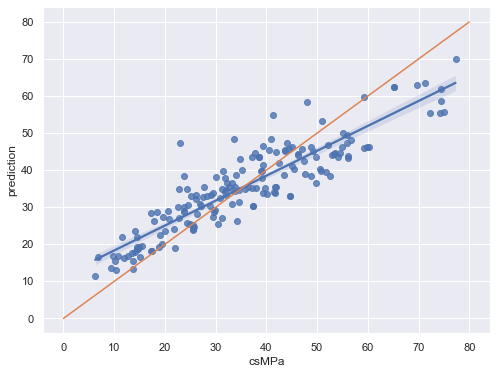

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.regplot(data = data, x='csMPa', y='prediction')
sns.lineplot([0,80],[0,80])

In [70]:
values = [(c,imp) for c, imp in zip(df.columns[:-1], model.bestModel.stages[2].featureImportances.toArray())]
for elt in values:
    print('{}: {}'.format(elt[0], elt[1]))

cement: 0.26050558947136826
slag: 0.059311523130990994
flyash: 0.0422338506152291
water: 0.13039961347695056
superplasticizer: 0.07178791564944192
coarseaggregate: 0.031731960281061136
fineaggregate: 0.044049014743459416
age: 0.35998053263149865


# 2. For the following given inputs, what would be the estimated cement strength?

- Cement: 540
- Blast Furnace Slag: 0
- Fly Ash: 0
- Water: 162
- Superplasticizer: 2.5
- Coarse Aggregate: 1040
- Fine Aggregate: 676
- Age: 28

The correct answer is 79.99. Let's how close your prediction is!

In [73]:
user_values = [(540,0,0,162,2.5,1040,676,28)]
col_names = df.columns[:-1]
user_df = spark.createDataFrame(user_values, col_names)
user_df.show()

+------+----+------+-----+----------------+---------------+-------------+---+
|cement|slag|flyash|water|superplasticizer|coarseaggregate|fineaggregate|age|
+------+----+------+-----+----------------+---------------+-------------+---+
|   540|   0|     0|  162|             2.5|           1040|          676| 28|
+------+----+------+-----+----------------+---------------+-------------+---+



In [76]:
pred = model.transform(user_df)
pred.select('prediction').show()

+----------------+
|      prediction|
+----------------+
|60.1444448291169|
+----------------+

